In [70]:
import pandas as pd
import numpy as np
import os
import cv2
import easyocr
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import io
import PIL.Image
if not hasattr(PIL.Image, 'Resampling'):
    PIL.Image.Resampling = PIL.Image
from PIL import Image


In [71]:
# image directory
image_dir = '../images/aculei-images/'

In [72]:
# reading the dataframe
df = pd.read_csv('../datasets/ocr.csv', index_col=0)
df_ocr = df.copy()

In [73]:
df_ocr.head()

,hash,image_name,camera,date_time,date,time,moon,temp
0,00100018fdffffff,TF_ACULEI_8040_DSCF0129.jpg,CAM_1,2021-07-22 23:04:07,2021-07-22,23:04:07,Full Moon,NaN
1,000000b8fcfcffff,TF_ACULEI_900_DSCF0756.jpg,CAM_1,2021-05-27 22:01:44,2021-05-27,22:01:44,Full Moon,16°C
2,0000001000787f7f,TF_ACULEI_15294_DSCF0133.jpg,CAME,2023-03-30 20:35:58,2023-03-30,20:35:58,First Quarter,9°C
3,0000001e1e3cfe7f,TF_ACULEI_11374_DSCF0064.jpg,CAM_6,2022-06-09 21:29:59,2022-06-09,21:29:59,Waxing Gibbous,15°C
4,00080818fcfeffff,TF_ACULEI_4106_DSCF4336.jpg,CAM_1,2021-06-16 23:41:09,2021-06-16,23:41:09,First Quarter,19°C


In [74]:
#Extracting rows with null temps
temp_rows = df_ocr[df_ocr['temp'].isnull()]
temp_rows_subset = temp_rows[0:4]

In [75]:
temp_rows_subset.head()

,hash,image_name,camera,date_time,date,time,moon,temp
0,00100018fdffffff,TF_ACULEI_8040_DSCF0129.jpg,CAM_1,2021-07-22 23:04:07,2021-07-22,23:04:07,Full Moon,NaN
5,000800b8fcfdfffd,TF_ACULEI_1601_DSCF1490.jpg,CAM_1,2021-06-02 00:39:46,2021-06-02,00:39:46,Last Quarter,NaN
9,fc78080038fcfc78,TF_ACULEI_2994_DSCF3044.jpg,CAM_1,2021-06-10 21:55:12,2021-06-10,21:55:12,New Moon,NaN
10,00080878f8fdfffe,TF_ACULEI_3901_DSCF4119.jpg,CAM_1,2021-06-16 00:22:58,2021-06-16,00:22:58,First Quarter,NaN


In [76]:
temp_rows.head()

,hash,image_name,camera,date_time,date,time,moon,temp
0,00100018fdffffff,TF_ACULEI_8040_DSCF0129.jpg,CAM_1,2021-07-22 23:04:07,2021-07-22,23:04:07,Full Moon,NaN
5,000800b8fcfdfffd,TF_ACULEI_1601_DSCF1490.jpg,CAM_1,2021-06-02 00:39:46,2021-06-02,00:39:46,Last Quarter,NaN
9,fc78080038fcfc78,TF_ACULEI_2994_DSCF3044.jpg,CAM_1,2021-06-10 21:55:12,2021-06-10,21:55:12,New Moon,NaN
10,00080878f8fdfffe,TF_ACULEI_3901_DSCF4119.jpg,CAM_1,2021-06-16 00:22:58,2021-06-16,00:22:58,First Quarter,NaN
11,0000003c3effffff,TF_ACULEI_10109_DSCF0574.jpg,CAM_1,2021-12-16 02:24:38,2021-12-16,02:24:38,Waxing Gibbous,NaN


In [77]:
temp_rows.shape

(6417, 8)

In [78]:
reader = easyocr.Reader(['en'], gpu=True) 

In [98]:
def crop_bottom_third_and_display(image_path):
    # Open and display the original image
    img = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    # get image dimensions
    width, height = img.size
    
    # define the coordinates for cropping
    left = 0
    upper = 0
    right = width
    lower = int(height * 17 / 18)  # keep only the bottom 1/3 of the image
    
    # Crop the bottom third of the image
    cropped_img = img.crop((left, lower, right, height))
    output = io.BytesIO()
    cropped_img.save(output, format='JPEG')  # Change format as needed (JPEG, PNG, etc.)
    cropped_img_bytes = output.getvalue()

    # Display the cropped image
    cropped_img = Image.open(io.BytesIO(cropped_img_bytes))
    plt.subplot(1, 2, 2)
    plt.title('Cropped Image (Bottom Third)')
    plt.imshow(cropped_img)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return cropped_img_bytes

  0%|          | 0/4 [00:00<?, ?it/s]

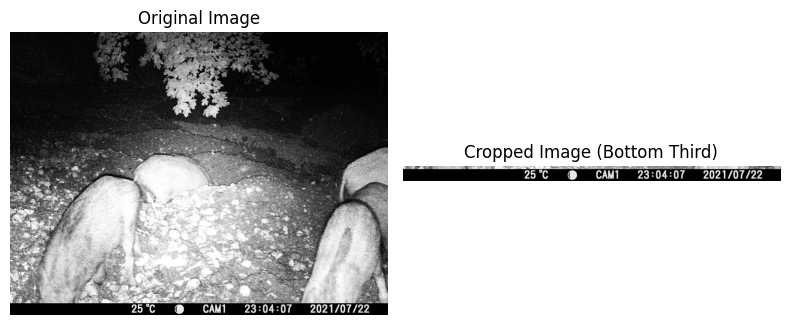

 25%|██▌       | 1/4 [00:01<00:05,  1.95s/it]

../images/aculei-images/TF_ACULEI_8040_DSCF0129.jpg


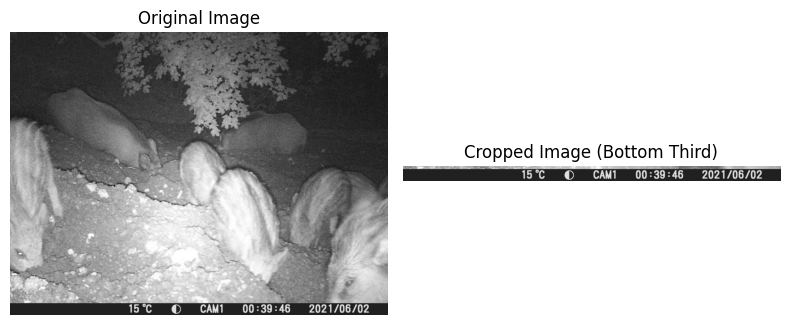

 50%|█████     | 2/4 [00:03<00:03,  1.55s/it]

../images/aculei-images/TF_ACULEI_1601_DSCF1490.jpg


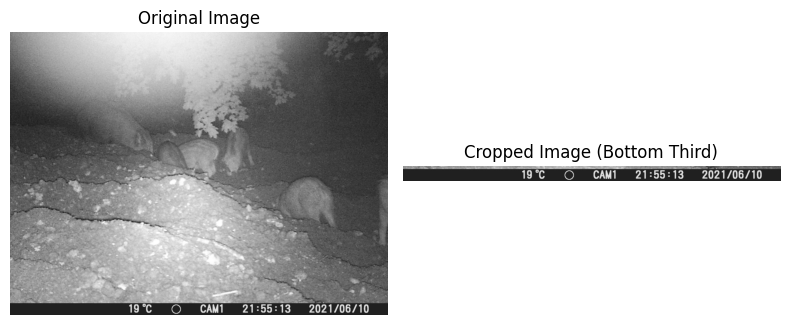

 75%|███████▌  | 3/4 [00:04<00:01,  1.38s/it]

../images/aculei-images/TF_ACULEI_2994_DSCF3044.jpg


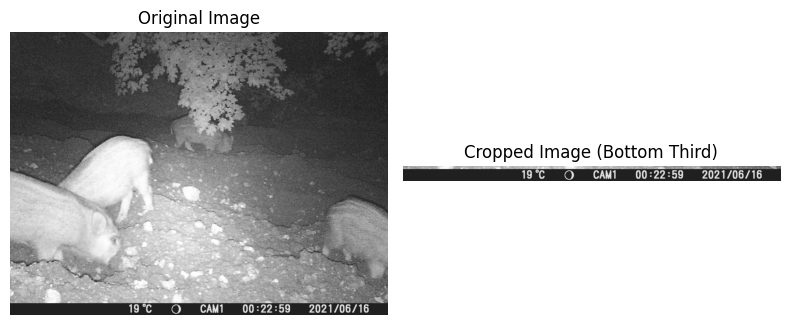

100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

../images/aculei-images/TF_ACULEI_3901_DSCF4119.jpg


In [100]:
for index, row in tqdm(temp_rows_subset.iterrows(), total=len(temp_rows_subset)):
    image_path = os.path.join(image_dir, row['image_name'])
    if os.path.isdir(image_path) and image_path.startswith("."):
        continue 
    
    
    resized_image_bytes = crop_bottom_third_and_display(image_path)
    resize_image = Image.open(io.BytesIO(resized_image_bytes))
    text = reader.readtext(resized_image_bytes)
    print(text)
    print(image_path)
    # saving the temp always
    # celsius_pattern = r'\b\d+\s*[°]\s*C\b'
    # celsius_matches = re.findall(celsius_pattern, text)
    # df_ocr.loc[index, 'temp'] = celsius_matches[0] if celsius_matches else None
